### Reference: [LIPNET: END-TO-END SENTENCE-LEVEL LIPREADING](https://arxiv.org/abs/1611.01599)

# 1. Imports

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Helper functions

In [20]:
def load_video(path:str) -> List[float]: 
    capture = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = capture.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    capture.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [22]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [69]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

## 2.1 Callbacks

In [93]:
def init_callbacks():
    checkpoint_path = os.path.join('lipnet_checkpoints', 'cp.ckpt')

    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
    #                                                   patience=3,
    #                                                   verbose=1)

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          #save_best_only=True,
                                                          monitor='loss',
                                                          save_weights_only=True)

    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',  
                                                     factor=0.2,
                                                     patience=2,
                                                     verbose=1, 
                                                     min_lr=1e-7)
    return model_checkpoint, reduce_learning_rate

# 3. Where data?

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [10]:
vocabulary = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [124]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size: {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size: 40)


In [24]:
test_path = os.path.join('data', 's1', 'bbal7s.mpg')
test_path

'data/s1/bbal7s.mpg'

In [18]:
# Get filename as tensor
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bba16n'

In [28]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
frames, alignments

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.3895695 ],
          [1.3895695 ],
          [1.3895695 ],
          ...,
          [0.3380034 ],
          [0.2253356 ],
          [0.2253356 ]],
 
         [[1.3144577 ],
          [1.3520136 ],
          [1.3895695 ],
          ...,
          [0.3380034 ],
          [0.2253356 ],
          [0.2253356 ]],
 
         [[1.4646814 ],
          [1.4646814 ],
          [1.3895695 ],
          ...,
          [0.30044746],
          [0.26289153],
          [0.26289153]],
 
         ...,
 
         [[1.0140102 ],
          [1.0140102 ],
          [1.0140102 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.97645426],
          [0.97645426],
          [0.97645426],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.97645426],
          [0.97645426],
          [0.97645426],
          ...,
          [0.        ],
    

In [31]:
[bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]

['b',
 'i',
 'n',
 ' ',
 'b',
 'l',
 'u',
 'e',
 ' ',
 'a',
 't',
 ' ',
 'l',
 ' ',
 's',
 'e',
 'v',
 'e',
 'n',
 ' ',
 's',
 'o',
 'o',
 'n']

In [30]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>

In [32]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 4. Prepare data

In [45]:
data = tf.data.Dataset.list_files(os.path.join('data', 's1', '*.mpg'))
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [46]:
len(train), len(test)

(450, 50)

In [47]:
frames, alignments = data.as_numpy_iterator().next()

In [48]:
len(frames)

2

In [50]:
sample = data.as_numpy_iterator()
sample

In [51]:
val = sample.next(); val[0]

array([[[[[1.442852  ],
          [1.442852  ],
          [1.5149946 ],
          ...,
          [0.2885704 ],
          [0.3246417 ],
          [0.3246417 ]],

         [[1.5149946 ],
          [1.3707094 ],
          [1.5871371 ],
          ...,
          [0.2885704 ],
          [0.3246417 ],
          [0.3246417 ]],

         [[1.4789233 ],
          [1.4789233 ],
          [1.5149946 ],
          ...,
          [0.360713  ],
          [0.360713  ],
          [0.360713  ]],

         ...,

         [[1.1542816 ],
          [1.082139  ],
          [1.082139  ],
          ...,
          [9.198181  ],
          [9.198181  ],
          [9.16211   ]],

         [[1.082139  ],
          [1.082139  ],
          [1.082139  ],
          ...,
          [9.198181  ],
          [0.0360713 ],
          [0.0360713 ]],

         [[1.082139  ],
          [1.082139  ],
          [1.082139  ],
          ...,
          [9.198181  ],
          [9.198181  ],
          [9.198181  ]]],


        [[[1.4067

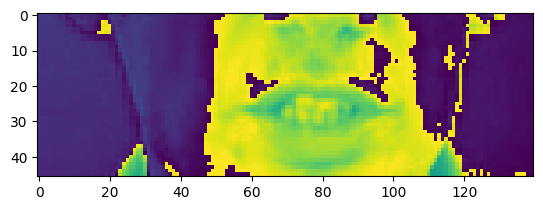

In [54]:
plt.imshow(val[0][0][35])

In [55]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place sp blue with x zero now'>

# 5. Fun stuff

In [57]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [106]:
def get_lipnet_model():
    model = Sequential()
    model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))
    
    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))
    
    model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

    print('Input shape:',model.input_shape)
    print('Output shape:',model.output_shape)
    model.save(os.path.join('models', 'lipnet_untrained'))
    return model

In [128]:
class LoadSample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        pred = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(pred, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(pred)):           
            print('\nOriginal:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('\n')

In [103]:
def lipnet(train_data=None, valid_data = None):
    model = get_lipnet_model()
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)
    model_checkpoint, reduce_learning_rate = init_callbacks()
    
    test_callback = LoadSample(test)
    
    history = model.fit(train_data, 
                        validation_data=valid_data,
                        epochs=100,
                        validation_steps=int(0.1 * len(valid_data)),
                        callbacks=[model_checkpoint, reduce_learning_rate, test_callback])
    preds = model.predict(val[0])
    print('Predicted: ',tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in preds[0]]))
    # print('Acutal: ', [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])
    model.save(os.path.join('models', 'lipnet_trained'))
    return history
    

In [107]:
lipnet(train_data=train, valid_data=test)

Input shape: (None, 75, 46, 140, 1)
Output shape: (None, 75, 41)


INFO:tensorflow:Assets written to: models/lipnet_untrained/assets


INFO:tensorflow:Assets written to: models/lipnet_untrained/assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_39 (Activation)  (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 75, 23, 70, 128)   0         
 ng3D)                                                           
                                                                 
 conv3d_40 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_40 (Activation)  (None, 75, 23, 70, 256)   0         
                                                     

KeyboardInterrupt: 

### Lol training is going to take way too long. Using pre-trained weights instead.

In [100]:
gdown.extractall('weights/epoch_96.zip')

['weights/checkpoint.index',
 'weights/__MACOSX/._checkpoint.index',
 'weights/checkpoint.data-00000-of-00001',
 'weights/__MACOSX/._checkpoint.data-00000-of-00001',
 'weights/checkpoint',
 'weights/__MACOSX/._checkpoint']

In [3]:
lipnet_model = tf.keras.models.load_model(os.path.join('models', 'lipnet_untrained'), compile=False)
lipnet_model.load_weights('weights/checkpoint')

2023-12-21 04:13:27.753539: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-21 04:13:27.753572: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-21 04:13:27.753578: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-21 04:13:27.753611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-21 04:13:27.753630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


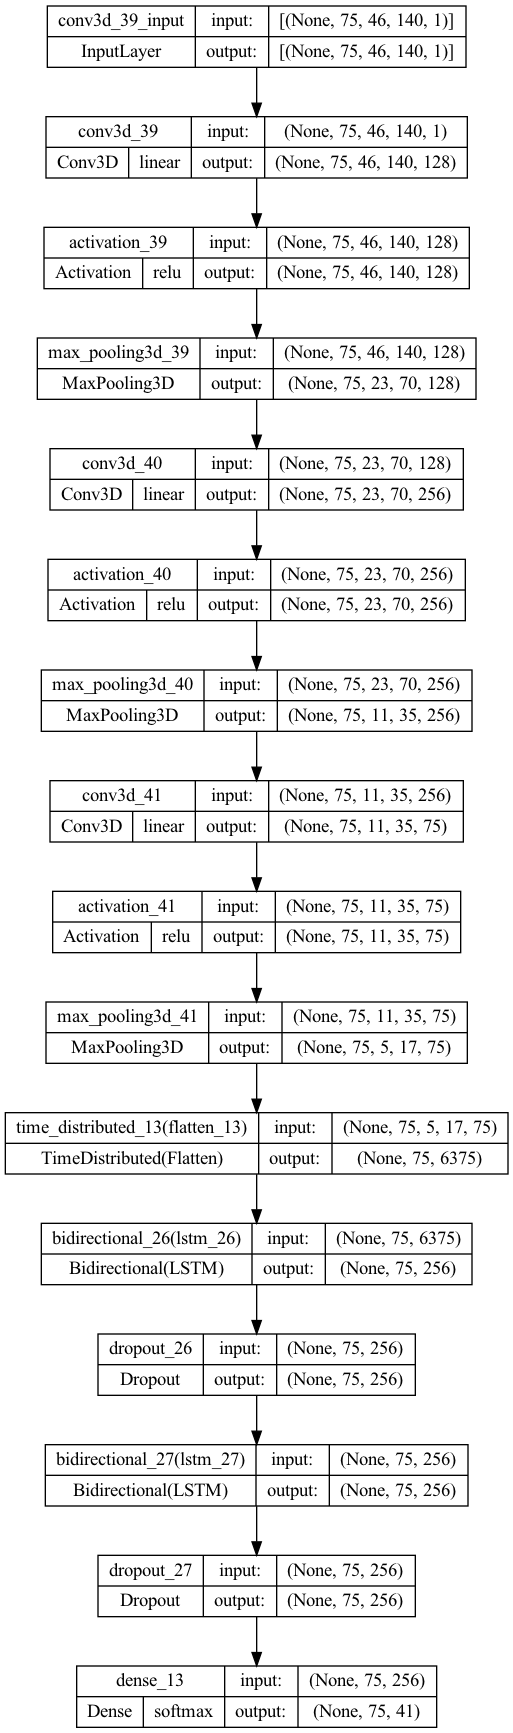

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(lipnet_model, show_shapes=True, show_layer_activations=True)

# 6. Test

In [113]:
test_data = test.as_numpy_iterator()
test_data

In [114]:
sample = test_data.next()
sample

[mpeg1video @ 0x3f5bb3ba0] ac-tex damaged at 22 17
[mpeg1video @ 0x3f5bb3ba0] Warning MVs not available


(array([[[[[1.4196706 ],
           [1.4196706 ],
           [1.4196706 ],
           ...,
           [0.        ],
           [9.339938  ],
           [9.11578   ]],
 
          [[1.4196706 ],
           [1.4196706 ],
           [1.4196706 ],
           ...,
           [9.0410595 ],
           [9.11578   ],
           [9.302578  ]],
 
          [[1.344951  ],
           [1.344951  ],
           [1.344951  ],
           ...,
           [9.153139  ],
           [9.526736  ],
           [9.526736  ]],
 
          ...,
 
          [[0.97135353],
           [0.97135353],
           [0.9339938 ],
           ...,
           [0.0747195 ],
           [0.11207926],
           [0.11207926]],
 
          [[0.97135353],
           [0.97135353],
           [0.9339938 ],
           ...,
           [0.        ],
           [0.0747195 ],
           [0.03735975]],
 
          [[0.97135353],
           [0.97135353],
           [0.9339938 ],
           ...,
           [0.03735975],
           [0.03735975

In [123]:
from IPython.display import Video
Video(os.path.join('data', 's1', 'pbii2p.mpg'), embed=True)

In [115]:
prediction = lipnet_model.predict(sample[0])
print('\nActual:', [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]])
decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75,75], greedy=True)[0][0].numpy()
print('\nPredicted:', [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])

1/1 [==============================] - 2s 2s/step

Actual: [<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in i two please'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay red by y eight now'>]

Predicted: [<tf.Tensor: shape=(), dtype=string, numpy=b'place blue in i two please'>, <tf.Tensor: shape=(), dtype=string, numpy=b'lay red by y eght now'>]


# 6.1 Test with video

In [116]:
test_video = load_data(tf.convert_to_tensor(os.path.join('data', 's1', 'swwv7s.mpg')))

In [125]:
print('Actual:', [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [test_video[1]]])
prediction = lipnet_model.predict(tf.expand_dims(test_video[0], axis=0))
decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75], greedy=True)[0][0].numpy()

print('Predicted:', [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded])

Actual: [<tf.Tensor: shape=(), dtype=string, numpy=b'set white with v seven soon'>]
1/1 [==============================] - 1s 1s/step
Predicted: [<tf.Tensor: shape=(), dtype=string, numpy=b'set white with v seven soon'>]


In [127]:
Video(os.path.join('data', 's1', 'swwv7s.mpg'), embed=True)

# End